In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "..")
from classes.nn_classes import NNmodel
from classes.nn_classes import train_model as train_model_with_batch
from torch.utils.data import Dataset, DataLoader

In [2]:
data_flat = np.loadtxt('labeled_clusters_1000.txt')
positions_from_file = data_flat[:,:24].reshape(-1,12,2)
energies_from_file = data_flat[:,24:25].reshape(-1)
labels_from_file = data_flat[:,-1:].reshape(-1).astype('int')

[-35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18
 -17 -16 -15 -14 -13 -12 -11]


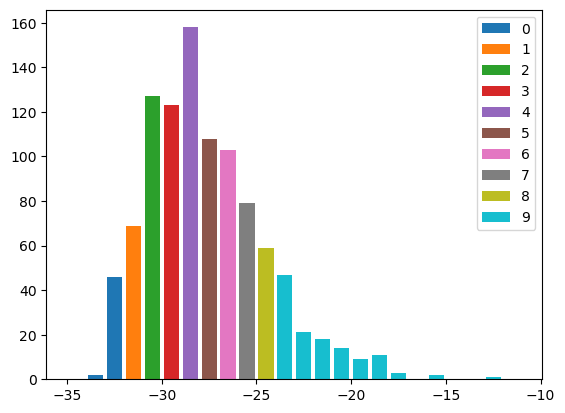

In [3]:
fig, ax = plt.subplots()

energy_range = np.arange(-35,-10, 1)#np.linspace(-40,40, 80)
print(energy_range)
for label in range(0, 10):
    indices = np.argwhere(labels_from_file == label)
    energies = energies_from_file[indices]
    hist, bin_edges = np.histogram(energies, bins=energy_range)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    ax.bar(bin_centers, hist, label=f"{label}", color=f"C{label}")
ax.legend()

In [4]:
class DistanceMoments():
    def __init__(self, beta=3.0) -> None:
        self.beta = beta

    def calculate_moment(self, atom_poses):
        mus_tot = np.zeros(shape=(len(atom_poses), 4))
        for i, atom_pos in enumerate(atom_poses):
            xs, ys = atom_pos[:,0], atom_pos[:,1]
            vec_mean = np.array([np.mean(xs), np.mean(ys)])
            mus = np.zeros(4)
            for j in range(1,5):
                sum_res = np.sum(((xs-vec_mean[0])**2+(ys-vec_mean[1])**2)**j)
                mus[j-1] = self.beta**(-j)*sum_res
            mus_tot[i] = mus
        return mus_tot

In [5]:
class CustomDataset(Dataset):
    def __init__(self, dist_moms, labels) -> None:
        super().__init__()
        self.dist_moms = dist_moms
        self.labels = labels

    def __getitem__(self, index):
        return self.dist_moms[index], self.labels[index]
    
    def __len__(self):
        return len(self.dist_moms)
    

In [6]:
labels = []
dist_moms = []
dist_mom_calculator = DistanceMoments()

for label in range(0, 10):
    indices = np.argwhere(labels_from_file == label)
    poses = positions_from_file[indices].squeeze(1)
    dist_moms.append(dist_mom_calculator.calculate_moment(atom_poses=poses))
    labels.append(label*np.ones(len(poses)))

In [23]:
labels = torch.tensor([], dtype=torch.long)
dist_moms = torch.tensor([], dtype=torch.float)
dist_mom_calculator = DistanceMoments()

for label in range(0, 10):
    indices = np.argwhere(labels_from_file == label)
    poses = positions_from_file[indices].squeeze(1)
    dist_moms = torch.concat((dist_moms, torch.tensor(dist_mom_calculator.calculate_moment(atom_poses=poses), dtype=torch.float)))
    labels = torch.concat((labels, torch.tensor(label*np.ones(len(poses)),dtype=torch.int64)))
random_perm = torch.randperm(dist_moms.size()[0])
dist_moms = dist_moms[random_perm]
labels = labels[random_perm]

In [24]:
train_data = CustomDataset(dist_moms=dist_moms[0:799], labels=labels[0:799])
val_data = CustomDataset(dist_moms=dist_moms[799:899], labels=labels[799:899])
test_data = CustomDataset(dist_moms=dist_moms[899:999], labels=labels[899:999])

train_loader = DataLoader(train_data, batch_size=20, shuffle=True)
val_loader = DataLoader(val_data, batch_size=20, shuffle=True)
test_loader = DataLoader(test_data, batch_size=20, shuffle=True)

In [35]:
class PredictModel(NNmodel):
    def __init__(self, input_dim, output_dim, num_hidden_layers, dim_hiddens, activation_func, bias=True) -> None:
        super().__init__(input_dim, output_dim, num_hidden_layers, dim_hiddens, activation_func, bias)
        self.softmax = torch.nn.Softmax(dim=1)
        
    def predict(self, x):
        return torch.argmax(self.softmax(self.forward(x)), dim=1)


N_hiddens = [2,4]
hidden_dims = [6,12]
models = []
model_val_losses = []
model_train_losses = []
for N_hidden in N_hiddens:
    for hidden_dim in hidden_dims:
        model = PredictModel(input_dim=4, output_dim=10, num_hidden_layers=N_hidden, dim_hiddens=hidden_dim, activation_func=torch.nn.SiLU(), bias=True)
        optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
        train_losses, val_losses = train_model_with_batch(epochs=10000, model=model, 
                                                  train_loader=train_loader, 
                                                  val_loader=val_loader,
                                                  optimizer=optimizer,
                                                  early_stopping=True,
                                                  patience=500,
                                                  loss_func=torch.nn.CrossEntropyLoss())
        model_val_losses.append(val_losses)
        model_train_losses.append(train_losses)
        models.append(model)

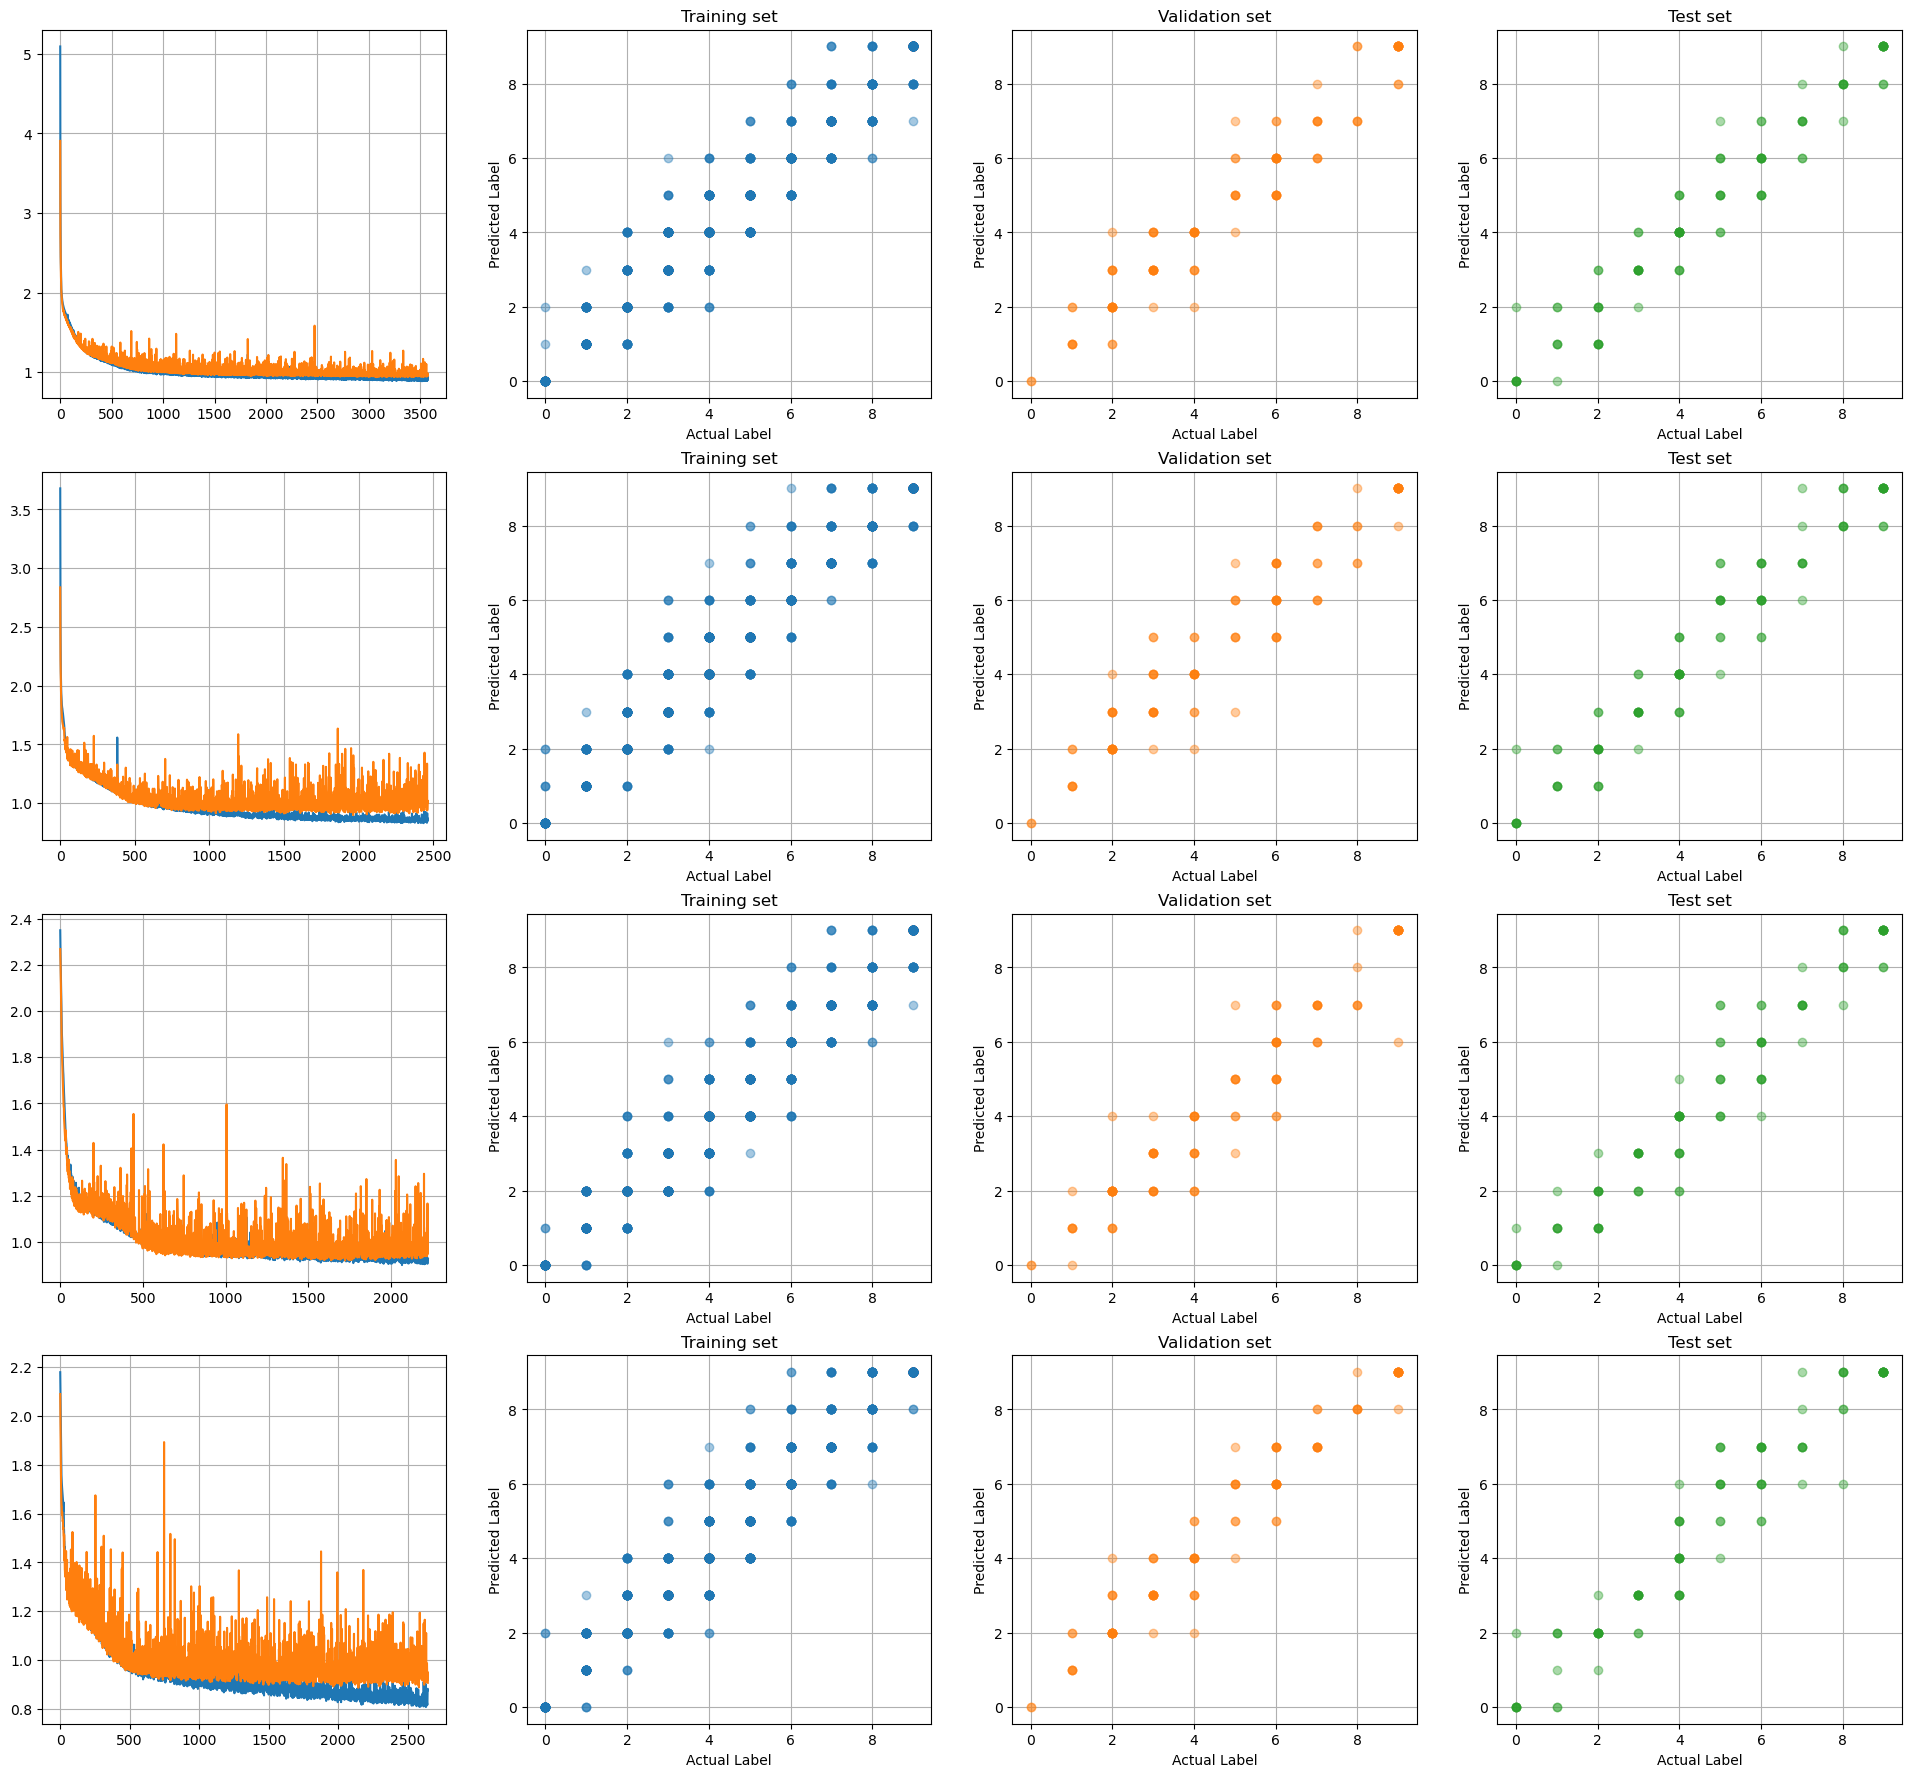

In [44]:
fig, axs = plt.subplots(4,4, figsize=(24, 22))
for ax in axs.flatten():
    ax.grid()

for model, model_train_loss, model_val_loss, ax_row in zip(models, model_train_losses, model_val_losses, axs):
    with torch.no_grad():
        epochs = torch.linspace(0.0, len(model_train_loss), len(model_train_loss))
        ax_row[0].plot(epochs, model_train_loss, label="train-loss")
        ax_row[0].plot(epochs, model_val_loss, label="validation-loss")
        for i, data_loader, ax, title in zip(range(0,3), [train_loader, val_loader, test_loader], ax_row[1:], ["Training set", "Validation set", "Test set"]):
            for dist_mom, label in data_loader:
                pred_label = model.predict(dist_mom)
                ax.set_ylabel("Predicted Label")
                ax.set_xlabel("Actual Label")
                ax.set_title(title)
                ax.plot(label, pred_label, "o", color=f"C{i}", alpha=0.4)